In [1]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
#Data loading from google drive
btc = pd.read_csv('/content/drive/MyDrive/Bitcoin.csv')
eth = pd.read_csv('/content/drive/MyDrive/Ethereum.csv')
lite = pd.read_csv('/content/drive/MyDrive/litecoin.csv')

In [3]:
btc.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2014-09-17,468.174011,452.421997,465.864014,457.334015,21056800,457.334015
1,2014-09-18,456.859985,413.104004,456.859985,424.440002,34483200,424.440002
2,2014-09-19,427.834991,384.532013,424.102997,394.795990,37919700,394.795990
3,2014-09-20,423.295990,389.882996,394.673004,408.903992,36863600,408.903992
4,2014-09-21,412.425995,393.181000,408.084991,398.821014,26580100,398.821014


In [4]:
eth.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2017-11-09,329.451996,307.056000,308.644989,320.884003,893249984,320.884003
1,2017-11-10,324.717987,294.541992,320.670990,299.252991,885985984,299.252991
2,2017-11-11,319.453003,298.191986,298.585999,314.681000,842300992,314.681000
3,2017-11-12,319.153015,298.513000,314.690002,307.907990,1613479936,307.907990
4,2017-11-13,328.415009,307.024994,307.024994,316.716003,1041889984,316.716003


In [5]:
lite.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-08-01,4.64418,4.07290,4.63908,4.15320,6284530,4.15320
1,2015-08-02,4.19908,3.85891,4.08738,4.17491,6950580,4.17491
2,2015-08-03,4.37425,4.03877,4.16947,4.16219,5494590,4.16219
3,2015-08-04,4.47226,4.18262,4.18342,4.37793,4323960,4.37793
4,2015-08-05,4.42543,4.30105,4.37433,4.34922,2565020,4.34922


In [6]:
#Taking the closing prices
btcdf = btc.reset_index()['Close']
ethdf = eth.reset_index()['Close']
litedf = lite.reset_index()['Close']

In [7]:
btcdf.shape

(2719,)

In [8]:
ethdf.shape

(1570,)

In [9]:
litedf.shape

(2401,)

In [10]:
btcdf.isnull().sum()

0

In [11]:
ethdf.isnull().sum()

0

In [12]:
litedf.isnull().sum()

0

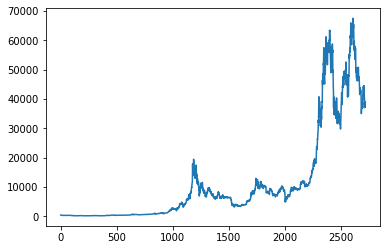

In [13]:
plt.plot(btcdf)

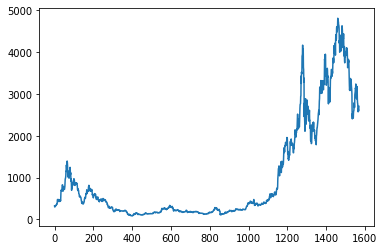

In [14]:
plt.plot(ethdf)

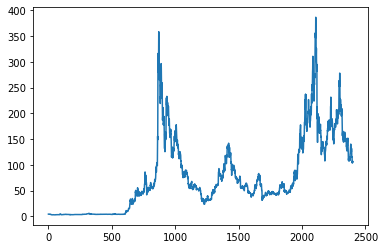

In [15]:
plt.plot(litedf)

In [16]:
#splitting the data to train and test
training_sizebtc = int(len(btcdf)*0.70)
training_sizeeth = int(len(ethdf)*0.70)
training_sizelite = int(len(litedf)*0.70)
test_sizebtc = len(btcdf) - training_sizebtc
test_sizeeth = len(ethdf) - training_sizeeth
test_sizelite = len(litedf) - training_sizelite


In [17]:
trainbtc = btcdf[0:training_sizebtc].values.reshape(-1,1)
testbtc = btcdf[training_sizebtc:].values.reshape(-1,1)

In [18]:
traineth = ethdf[0:training_sizeeth].values.reshape(-1,1)
testeth = ethdf[training_sizeeth:].values.reshape(-1,1)


In [19]:
trainlite = litedf[0:training_sizelite].values.reshape(-1,1)
testlite = litedf[training_sizelite:].values.reshape(-1,1)

In [20]:
def create_dataset(dataset,time_step=60):
  dataX,dataY = [],[]

  for i in range(len(dataset) - time_step):
    x = dataset[i:(i+time_step),0]
    dataX.append(x)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX),np.array(dataY)

### **Bitcoin** **price** **prediction**

In [21]:
#scaling the data
scaler_trainbtc = MinMaxScaler(feature_range=(0,1))
scaledbtctrain = scaler_trainbtc.fit_transform(trainbtc)

scaler_testbtc = MinMaxScaler(feature_range=(0,1))
scaledbtctest = scaler_testbtc.fit_transform(testbtc)

In [22]:
#Creating the datasets
x_trainbtc,y_trainbtc = create_dataset(scaledbtctrain)
x_testbtc,y_testbtc = create_dataset(scaledbtctest)


In [23]:
#Restructuring the data to 3D tensor for LSTM model
trainXbtc = np.reshape(x_trainbtc,(x_trainbtc.shape[0],x_trainbtc.shape[1],1))
testXbtc = np.reshape(x_testbtc,(x_testbtc.shape[0],x_testbtc.shape[1],1))

In [24]:
#btc model building

In [25]:
btcmodel = Sequential()
btcmodel.add(Bidirectional(LSTM(units=128,activation='relu',return_sequences=True,input_shape=(trainXbtc.shape[1],trainXbtc.shape[2]))))
btcmodel.add(Dropout(0.5))
btcmodel.add(Bidirectional(LSTM(units = 64,input_shape=(trainXbtc.shape[1],trainXbtc.shape[2]))))
btcmodel.add(Dropout(0.5))
btcmodel.add(Dense(units = 1))
#btcmodel.summary()

In [26]:

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

btcmodel.compile(optimizer= 'adam',loss = 'mean_squared_error')
checkpoint_path = 'my_best_model.hdf5'

checkpoint= ModelCheckpoint(filepath = checkpoint_path,monitor='val_loss',verbose=1,save_best_only=True,mode='min')

earlystopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

callbacks = [checkpoint,earlystopping]
history = btcmodel.fit(trainXbtc,y_trainbtc,batch_size=32,epochs=300,verbose=1,shuffle=False,validation_data=(testXbtc,y_testbtc),callbacks=callbacks)

Epoch 1/300
58/58 [==============================] - ETA: 0s - loss: 0.0159
Epoch 1: val_loss improved from inf to 0.04388, saving model to my_best_model.hdf5
58/58 [==============================] - 33s 376ms/step - loss: 0.0159 - val_loss: 0.0439
Epoch 2/300
58/58 [==============================] - ETA: 0s - loss: 0.0229
Epoch 2: val_loss improved from 0.04388 to 0.01822, saving model to my_best_model.hdf5
58/58 [==============================] - 20s 341ms/step - loss: 0.0229 - val_loss: 0.0182
Epoch 3/300
58/58 [==============================] - ETA: 0s - loss: 0.0073
Epoch 3: val_loss improved from 0.01822 to 0.00708, saving model to my_best_model.hdf5
58/58 [==============================] - 20s 344ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 4/300
58/58 [==============================] - ETA: 0s - loss: 0.0060
Epoch 4: val_loss improved from 0.00708 to 0.00613, saving model to my_best_model.hdf5
58/58 [==============================] - 20s 353ms/step - loss: 0.0060 - val_loss:

In [27]:
#loss relative to epoch line graph

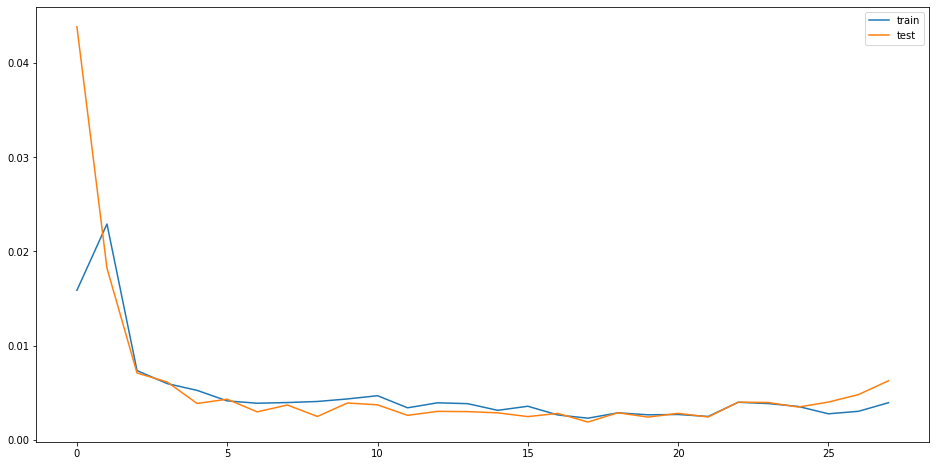

In [28]:
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label = 'test')
plt.legend()
plt.show()

In [29]:
scaledprediction = btcmodel.predict(testXbtc)
prediction = scaler_testbtc.inverse_transform(scaledprediction.reshape(-1,1))
test_actual = scaler_testbtc.inverse_transform(y_testbtc.reshape(-1,1))

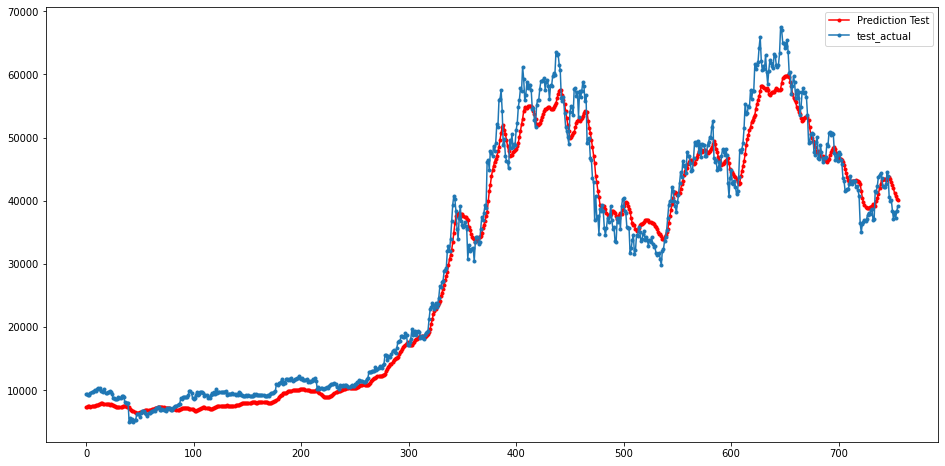

In [30]:
#plotting actual test prices and predicted btc prices
plt.figure(figsize=(16,8))
plt.plot(prediction,'r',marker='.',label='Prediction Test')
plt.plot(test_actual,marker='.',label='test_actual')
plt.legend()
plt.show()

In [31]:
#RMSE for test data
math.sqrt(mean_squared_error(test_actual,prediction))

2706.9778569281575

In [32]:
print(r2_score(test_actual,prediction))

0.9798707388581405


In [33]:

scaledpredictiontrain = btcmodel.predict(trainXbtc)
trainprediction = scaler_trainbtc.inverse_transform(scaledpredictiontrain.reshape(-1,1))
train_actual = scaler_trainbtc.inverse_transform(y_trainbtc.reshape(-1,1))

In [34]:
#RMSE for train data
math.sqrt(mean_squared_error(train_actual,trainprediction))

718.6329517419913

In [35]:
print(r2_score(train_actual,trainprediction))

0.9674083211252195


In [36]:
#Training the model on the whole dataset
btcscaler = MinMaxScaler(feature_range=(0,1))
scaledInputs1 = btcscaler.fit_transform(btcdf.values.reshape(-1,1))
inputs1,target1 = create_dataset(scaledInputs1)
#Restructuring the data to 3D tensor for LSTM model
clean_inputs1 = np.reshape(inputs1,(inputs1.shape[0],inputs1.shape[1],1))
#Model structure same as the one for evaluation
Finalbtcmodel = Sequential()
Finalbtcmodel.add(Bidirectional(LSTM(units=128,activation='relu',return_sequences=True,input_shape=(clean_inputs1.shape[1],clean_inputs1.shape[2]))))
Finalbtcmodel.add(Dropout(0.5))
Finalbtcmodel.add(Bidirectional(LSTM(units = 64)))
Finalbtcmodel.add(Dropout(0.5))
Finalbtcmodel.add(Dense(units = 1))

In [37]:
#Final Model training
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

Finalbtcmodel.compile(optimizer= 'adam',loss = 'mean_squared_error')
checkpoint_path1 = 'my_best_model.hdf5'

checkpoint1= ModelCheckpoint(filepath = checkpoint_path1,monitor='val_loss',verbose=1,save_best_only=True,mode='min')

earlystopping1 = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

callbacks1 = [checkpoint1,earlystopping1]
#will  use the validation  split to get the best model
historybtc = Finalbtcmodel.fit(clean_inputs1,target1,batch_size=32,epochs=300,verbose=1,shuffle=False,validation_split=(0.1),callbacks=callbacks1)

Epoch 1/300
75/75 [==============================] - ETA: 0s - loss: 0.0074
Epoch 1: val_loss improved from inf to 0.03837, saving model to my_best_model.hdf5
75/75 [==============================] - 33s 349ms/step - loss: 0.0074 - val_loss: 0.0384
Epoch 2/300
75/75 [==============================] - ETA: 0s - loss: 0.0174
Epoch 2: val_loss improved from 0.03837 to 0.00523, saving model to my_best_model.hdf5
75/75 [==============================] - 25s 336ms/step - loss: 0.0174 - val_loss: 0.0052
Epoch 3/300
75/75 [==============================] - ETA: 0s - loss: 0.0087
Epoch 3: val_loss did not improve from 0.00523
75/75 [==============================] - 25s 338ms/step - loss: 0.0087 - val_loss: 0.0393
Epoch 4/300
75/75 [==============================] - ETA: 0s - loss: 0.0092
Epoch 4: val_loss did not improve from 0.00523
75/75 [==============================] - 25s 335ms/step - loss: 0.0092 - val_loss: 0.0081
Epoch 5/300
75/75 [==============================] - ETA: 0s - loss: 0.0

In [38]:
import pickle
# saving the scaler
with open('btcscaler.pkl','wb') as f:
    pickle.dump(btcscaler,f)

In [39]:
#saving the model
Finalbtcmodel.save('btcmodel.h5')

## **Ethereum** **Price** **Prediction**

In [40]:
#scaling the data
scaler_traineth = MinMaxScaler(feature_range=(0,1))
scaledethtrain = scaler_traineth.fit_transform(traineth)

scaler_testeth = MinMaxScaler(feature_range=(0,1))
scaledethtest = scaler_testeth.fit_transform(testeth)

In [41]:
#Creating the datasets
x_traineth,y_traineth = create_dataset(scaledethtrain)
x_testeth,y_testeth = create_dataset(scaledethtest)

In [42]:
#Restructuring the data to 3D tensor for LSTM model
trainXeth = np.reshape(x_traineth,(x_traineth.shape[0],x_traineth.shape[1],1))
testXeth = np.reshape(x_testeth,(x_testeth.shape[0],x_testeth.shape[1],1))


In [43]:
#Creation of the Model
ethmodel = Sequential()
ethmodel.add(Bidirectional(LSTM(units=128,activation='relu',return_sequences=True,input_shape=(trainXeth.shape[1],trainXeth.shape[2]))))
ethmodel.add(Dropout(0.5))
ethmodel.add(Bidirectional(LSTM(units = 64)))
ethmodel.add(Dropout(0.5))
ethmodel.add(Dense(units = 1))

In [44]:
#Model training
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

ethmodel.compile(optimizer= 'adam',loss = 'mean_squared_error')
checkpoint_path2 = 'my_best_model.hdf5'

checkpoint2= ModelCheckpoint(filepath = checkpoint_path2,monitor='val_loss',verbose=1,save_best_only=True,mode='min')

earlystopping2 = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

callbacks2 = [checkpoint2,earlystopping2]
historyeth = ethmodel.fit(trainXeth,y_traineth,batch_size=32,epochs=300,verbose=1,shuffle=False,validation_data=(testXeth,y_testeth),callbacks=callbacks2)

Epoch 1/300
33/33 [==============================] - ETA: 0s - loss: 0.0340
Epoch 1: val_loss improved from inf to 0.07924, saving model to my_best_model.hdf5
33/33 [==============================] - 19s 380ms/step - loss: 0.0340 - val_loss: 0.0792
Epoch 2/300
33/33 [==============================] - ETA: 0s - loss: 0.0133
Epoch 2: val_loss improved from 0.07924 to 0.01640, saving model to my_best_model.hdf5
33/33 [==============================] - 11s 344ms/step - loss: 0.0133 - val_loss: 0.0164
Epoch 3/300
33/33 [==============================] - ETA: 0s - loss: 0.0055
Epoch 3: val_loss did not improve from 0.01640
33/33 [==============================] - 11s 344ms/step - loss: 0.0055 - val_loss: 0.0182
Epoch 4/300
33/33 [==============================] - ETA: 0s - loss: 0.0054
Epoch 4: val_loss did not improve from 0.01640
33/33 [==============================] - 11s 341ms/step - loss: 0.0054 - val_loss: 0.0262
Epoch 5/300
33/33 [==============================] - ETA: 0s - loss: 0.0

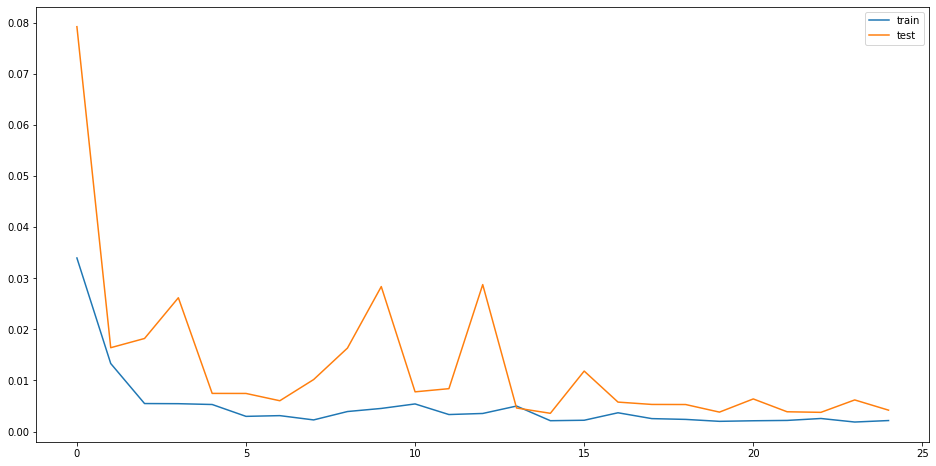

In [45]:
#Plotting the train loss and test validation loss
plt.figure(figsize=(16,8))
plt.plot(historyeth.history['loss'],label='train')
plt.plot(historyeth.history['val_loss'],label = 'test')
plt.legend()
plt.show()

In [46]:
#Tranforming the data to original data
ethscaledprediction = ethmodel.predict(testXeth)
ethprediction = scaler_testeth.inverse_transform(ethscaledprediction.reshape(-1,1))
ethtest_actual = scaler_testeth.inverse_transform(y_testeth.reshape(-1,1))

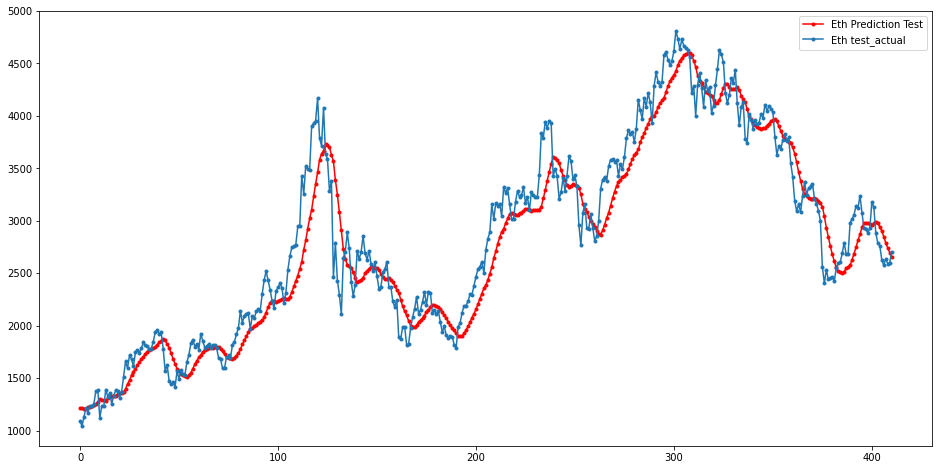

In [47]:
#plotting actual test prices and predicted ethereum prices
plt.figure(figsize=(16,8))
plt.plot(ethprediction,'r',marker='.',label='Eth Prediction Test')
plt.plot(ethtest_actual,marker='.',label='Eth test_actual')
plt.legend()
plt.show()

In [48]:
#RMSE for test data
math.sqrt(mean_squared_error(ethtest_actual,ethprediction))

260.5499157150538

In [49]:
#R squared value
print(r2_score(ethtest_actual,ethprediction))

0.9225345554688587


In [50]:
#transforming Xtrain data to original
ethscaledpredictiontrain = ethmodel.predict(trainXeth)
ethtrainprediction = scaler_traineth.inverse_transform(ethscaledpredictiontrain.reshape(-1,1))
ethtrain_actual = scaler_traineth.inverse_transform(y_traineth.reshape(-1,1))

In [51]:
#RMSE for train data
math.sqrt(mean_squared_error(ethtrain_actual,ethtrainprediction))

41.139275449031764

In [52]:
#R-squared for train data
print(r2_score(ethtrain_actual,ethtrainprediction))

0.9655717551401347


In [53]:
#Training the model on the whole dataset
Ethscaler = MinMaxScaler(feature_range=(0,1))
scaledInputs = Ethscaler.fit_transform(ethdf.values.reshape(-1,1))
inputs,target = create_dataset(scaledInputs)

In [54]:
#Restructuring the data to 3D tensor for LSTM model
clean_inputs = np.reshape(inputs,(inputs.shape[0],inputs.shape[1],1))

In [55]:
#Model structure same as the one for evaluation
Finalethmodel = Sequential()
Finalethmodel.add(Bidirectional(LSTM(units=128,activation='relu',return_sequences=True,input_shape=(clean_inputs.shape[1],clean_inputs.shape[2]))))
Finalethmodel.add(Dropout(0.5))
Finalethmodel.add(Bidirectional(LSTM(units = 64)))
Finalethmodel.add(Dropout(0.5))
Finalethmodel.add(Dense(units = 1))

In [56]:
#Final Model training
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

Finalethmodel.compile(optimizer= 'adam',loss = 'mean_squared_error')
checkpoint_path2 = 'my_best_model.hdf5'

checkpoint2= ModelCheckpoint(filepath = checkpoint_path2,monitor='val_loss',verbose=1,save_best_only=True,mode='min')

earlystopping2 = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

callbacks2 = [checkpoint2,earlystopping2]
#will  use the validation  split to get the best model
historyeth = Finalethmodel.fit(clean_inputs,target,batch_size=32,epochs=300,verbose=1,shuffle=False,validation_split=(0.1),callbacks=callbacks2)

Epoch 1/300
43/43 [==============================] - ETA: 0s - loss: 0.0150
Epoch 1: val_loss improved from inf to 0.05826, saving model to my_best_model.hdf5
43/43 [==============================] - 24s 380ms/step - loss: 0.0150 - val_loss: 0.0583
Epoch 2/300
43/43 [==============================] - ETA: 0s - loss: 0.0252
Epoch 2: val_loss improved from 0.05826 to 0.01589, saving model to my_best_model.hdf5
43/43 [==============================] - 15s 344ms/step - loss: 0.0252 - val_loss: 0.0159
Epoch 3/300
43/43 [==============================] - ETA: 0s - loss: 0.0114
Epoch 3: val_loss improved from 0.01589 to 0.01011, saving model to my_best_model.hdf5
43/43 [==============================] - 15s 345ms/step - loss: 0.0114 - val_loss: 0.0101
Epoch 4/300
43/43 [==============================] - ETA: 0s - loss: 0.0051
Epoch 4: val_loss did not improve from 0.01011
43/43 [==============================] - 15s 341ms/step - loss: 0.0051 - val_loss: 0.0217
Epoch 5/300
43/43 [=============

In [57]:

# saving the scaler
with open('Ethscaler.pkl','wb') as f:
    pickle.dump(Ethscaler,f)

In [58]:
# saving the model
Finalethmodel.save('ethmodel.h5')

## **Lite Coin Price Prediction Model**

In [59]:
#scaling the data
scaler_trainlite = MinMaxScaler(feature_range=(0,1))
scaledlitetrain = scaler_trainlite.fit_transform(trainlite)

scaler_testlite = MinMaxScaler(feature_range=(0,1))
scaledlitetest = scaler_testlite.fit_transform(testlite)


In [60]:
#Creating the datasets
x_trainlite,y_trainlite = create_dataset(scaledlitetrain)
x_testlite,y_testlite = create_dataset(scaledlitetest)

In [61]:
#Restructuring the data to 3D tensor for LSTM model
trainXlite = np.reshape(x_trainlite,(x_trainlite.shape[0],x_trainlite.shape[1],1))
testXlite = np.reshape(x_testlite,(x_testlite.shape[0],x_testlite.shape[1],1))

In [62]:
#Model structure same as the one for evaluation
litemodel = Sequential()
litemodel.add(Bidirectional(LSTM(units=128,activation='relu',return_sequences=True,input_shape=(trainXlite.shape[1],trainXlite.shape[2]))))
litemodel.add(Dropout(0.5))
litemodel.add(Bidirectional(LSTM(units = 64,input_shape=(trainXlite.shape[1],trainXlite.shape[2]))))
litemodel.add(Dropout(0.5))
litemodel.add(Dense(units = 1))

In [63]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

litemodel.compile(optimizer= 'adam',loss = 'mean_squared_error')
checkpoint_path3 = 'my_best_model.hdf5'

checkpoint3= ModelCheckpoint(filepath = checkpoint_path3,monitor='val_loss',verbose=1,save_best_only=True,mode='min')

earlystopping3 = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

callbacks3 = [checkpoint3,earlystopping3]
historylite = litemodel.fit(trainXlite,y_trainlite,batch_size=32,epochs=300,verbose=1,shuffle=False,validation_data=(testXlite,y_testlite),callbacks=callbacks3)

Epoch 1/300
51/51 [==============================] - ETA: 0s - loss: 0.0155
Epoch 1: val_loss improved from inf to 0.02684, saving model to my_best_model.hdf5
51/51 [==============================] - 25s 367ms/step - loss: 0.0155 - val_loss: 0.0268
Epoch 2/300
51/51 [==============================] - ETA: 0s - loss: 0.0140
Epoch 2: val_loss improved from 0.02684 to 0.01176, saving model to my_best_model.hdf5
51/51 [==============================] - 17s 342ms/step - loss: 0.0140 - val_loss: 0.0118
Epoch 3/300
51/51 [==============================] - ETA: 0s - loss: 0.0070
Epoch 3: val_loss improved from 0.01176 to 0.00409, saving model to my_best_model.hdf5
51/51 [==============================] - 17s 339ms/step - loss: 0.0070 - val_loss: 0.0041
Epoch 4/300
51/51 [==============================] - ETA: 0s - loss: 0.0034
Epoch 4: val_loss improved from 0.00409 to 0.00385, saving model to my_best_model.hdf5
51/51 [==============================] - 18s 346ms/step - loss: 0.0034 - val_loss:

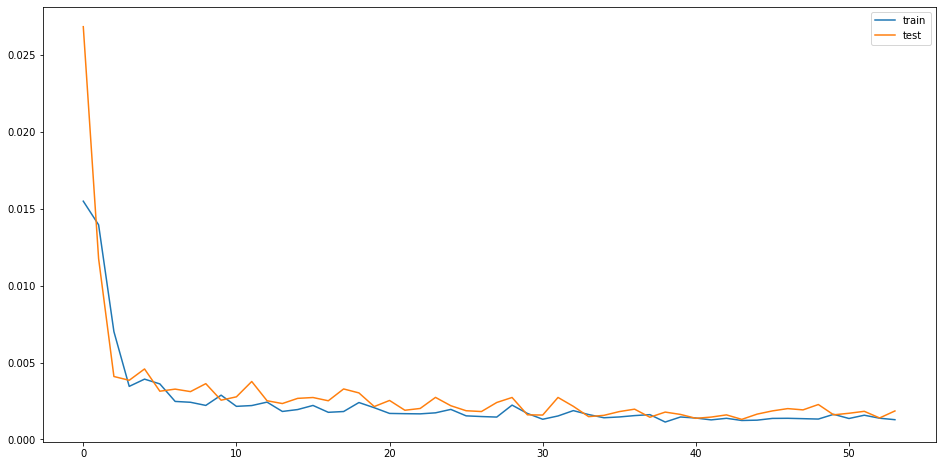

In [64]:
plt.figure(figsize=(16,8))
plt.plot(historylite.history['loss'],label='train')
plt.plot(historylite.history['val_loss'],label = 'test')
plt.legend()
plt.show()

In [65]:
litescaledprediction = litemodel.predict(testXlite)
liteprediction = scaler_testlite.inverse_transform(litescaledprediction.reshape(-1,1))
litetest_actual = scaler_testlite.inverse_transform(y_testlite.reshape(-1,1))

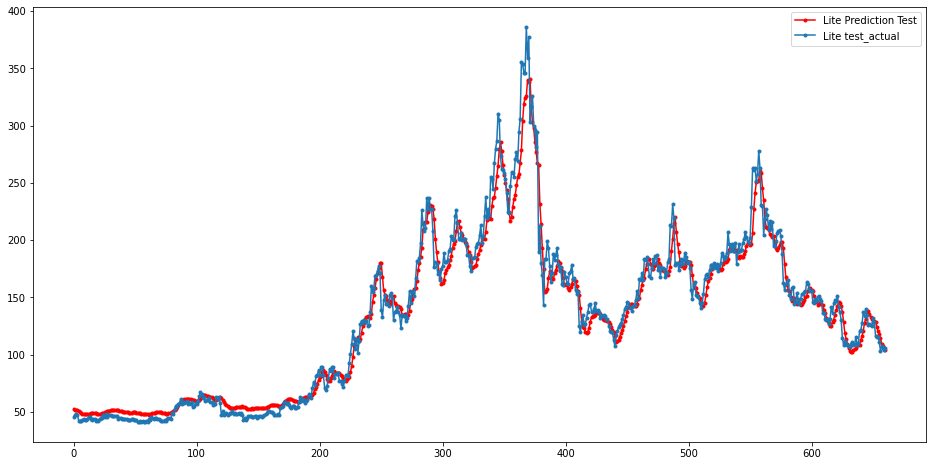

In [66]:
#plotting actual test prices and predicted btc prices
plt.figure(figsize=(16,8))
plt.plot(liteprediction,'r',marker='.',label='Lite Prediction Test')
plt.plot(litetest_actual,marker='.',label='Lite test_actual')
plt.legend()
plt.show()

In [67]:
#RMSE for test data
math.sqrt(mean_squared_error(litetest_actual,liteprediction))

12.839686913847617

In [68]:
r2_score(litetest_actual,liteprediction)

0.9672367600841495

In [69]:
litescaledpredictiontrain = litemodel.predict(trainXlite)
litetrainprediction = scaler_trainlite.inverse_transform(litescaledpredictiontrain.reshape(-1,1))
litetrain_actual = scaler_trainlite.inverse_transform(y_trainlite.reshape(-1,1))

In [70]:
#RMSE for train data
math.sqrt(mean_squared_error(litetrain_actual,litetrainprediction))

9.357543161452956

In [71]:
r2_score(litetrain_actual,litetrainprediction)

0.9739178431385038

In [72]:
#Training the model on the whole dataset
Litescaler = MinMaxScaler(feature_range=(0,1))
scaledInputs3 = Litescaler.fit_transform(litedf.values.reshape(-1,1))
inputs3,target3 = create_dataset(scaledInputs3)
#Restructuring the data to 3D tensor for LSTM model
clean_inputs3 = np.reshape(inputs3,(inputs3.shape[0],inputs3.shape[1],1))
#Model structure same as the one for evaluation
Finallitemodel = Sequential()
Finallitemodel.add(Bidirectional(LSTM(units=128,activation='relu',return_sequences=True,input_shape=(clean_inputs3.shape[1],clean_inputs3.shape[2]))))
Finallitemodel.add(Dropout(0.5))
Finallitemodel.add(Bidirectional(LSTM(units = 64))) 
Finallitemodel.add(Dropout(0.5))
Finallitemodel.add(Dense(units = 1))

In [73]:
#Final Model training
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

Finallitemodel.compile(optimizer= 'adam',loss = 'mean_squared_error')
checkpoint_path3 = 'my_best_model.hdf5'

checkpoint3= ModelCheckpoint(filepath = checkpoint_path3,monitor='val_loss',verbose=1,save_best_only=True,mode='min')

earlystopping3 = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

callbacks3 = [checkpoint3,earlystopping3]
#will  use the validation  split to get the best model
historylite = Finallitemodel.fit(clean_inputs3,target3,batch_size=32,epochs=300,verbose=1,shuffle=False,validation_split=(0.1),callbacks=callbacks3)

Epoch 1/300
66/66 [==============================] - ETA: 0s - loss: 0.0161
Epoch 1: val_loss improved from inf to 0.00517, saving model to my_best_model.hdf5
66/66 [==============================] - 30s 355ms/step - loss: 0.0161 - val_loss: 0.0052
Epoch 2/300
66/66 [==============================] - ETA: 0s - loss: 0.0141
Epoch 2: val_loss did not improve from 0.00517
66/66 [==============================] - 22s 331ms/step - loss: 0.0141 - val_loss: 0.0081
Epoch 3/300
66/66 [==============================] - ETA: 0s - loss: 0.0076
Epoch 3: val_loss did not improve from 0.00517
66/66 [==============================] - 23s 344ms/step - loss: 0.0076 - val_loss: 0.0053
Epoch 4/300
66/66 [==============================] - ETA: 0s - loss: 0.0044
Epoch 4: val_loss improved from 0.00517 to 0.00285, saving model to my_best_model.hdf5
66/66 [==============================] - 22s 330ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 5/300
66/66 [==============================] - ETA: 0s - loss: 0.0

In [74]:
# saving the scaler
with open('litescaler.pkl','wb') as f:
    pickle.dump(Litescaler,f)

In [75]:
Finallitemodel.save('litemodel.h5')